In [1]:
"""
=======================================================================
COMPLETE FEW-SHOT LEARNING - WITH EVALUATION METRICS
=======================================================================
"""

!pip install ultralytics seaborn scikit-learn -q

import kagglehub
import os
import json
import cv2
import random
import numpy as np
import xml.etree.ElementTree as ET
from collections import defaultdict
from tqdm import tqdm
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Set seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*70)
print("FEW-SHOT LEARNING FOR NOVEL OBJECT DETECTION")
print("IN AUTONOMOUS DRIVING")
print("="*70)
print(f"🔧 Device: {device}")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print("="*70)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.8 MB/s eta 0:00:0000:01
FEW-SHOT LEARNING FOR NOVEL OBJECT DETECTION
IN AUTONOMOUS DRIVING
🔧 Device: cuda
📅 Date: 2026-01-22 14:55:08
🎮 GPU: Tesla T4
💾 GPU Memory: 15.83 GB


In [2]:
"""
=======================================================================
CONFIGURATION - ALL ARGUMENTS
=======================================================================
"""

# Download datasets
print("📦 Downloading datasets...")
bdd_base = kagglehub.dataset_download("solesensei/solesensei_bdd100k")
voc_base = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

class Config:
    """
    ═══════════════════════════════════════════════════════════════════
    CONFIGURATION ARGUMENTS
    ═══════════════════════════════════════════════════════════════════
    """
    
    # ==================== DATASET PATHS ====================
    BDD_IMAGES_DIR = os.path.join(bdd_base, 'bdd100k/bdd100k/images/100k/val')
    BDD_LABELS_FILE = os.path.join(bdd_base, 'bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json')
    VOC_ROOT = os.path.join(voc_base, 'VOC2012_train_val/VOC2012_train_val')
    OUTPUT_DIR = '/kaggle/working/outputs'
    
    # ==================== IMAGE SETTINGS ====================
    IMAGE_HEIGHT = 384
    IMAGE_WIDTH = 640
    IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
    INPUT_CHANNELS = 3
    
    # ==================== MODEL ARCHITECTURE ====================
    BACKBONE = "CSPNet"
    BACKBONE_CHANNELS = [32, 64, 128, 256, 512]
    ENCODER = "Dilated Convolution"
    DILATION_RATES = [2, 4, 6, 8]
    DETECTION_HEAD = "Decoupled Head"
    CLS_CONV_LAYERS = 2
    REG_CONV_LAYERS = 4
    NUM_ANCHORS = 3
    
    # ==================== CATEGORIES ====================
    BASE_CATEGORIES = {
        'car': 0, 'truck': 1, 'bus': 2, 'person': 3, 'bike': 4,
        'motor': 5, 'traffic light': 6, 'traffic sign': 7, 'rider': 8,
    }
    NOVEL_CATEGORIES = {
        'dog': 9, 'cat': 10, 'cow': 11, 'horse': 12, 'sheep': 13, 'bird': 14,
    }
    
    NUM_BASE_CLASSES = len(BASE_CATEGORIES)      # 9
    NUM_NOVEL_CLASSES = len(NOVEL_CATEGORIES)    # 6
    NUM_CLASSES = NUM_BASE_CLASSES + NUM_NOVEL_CLASSES   # 15
    
    BASE_NAMES = list(BASE_CATEGORIES.keys())
    NOVEL_NAMES = list(NOVEL_CATEGORIES.keys())
    ALL_NAMES = BASE_NAMES + NOVEL_NAMES
    
    # ==================== TRAINING STAGE 1 ====================
    STAGE1_NAME = "Base Model Training"
    STAGE1_EPOCHS = 30
    STAGE1_LR = 1e-4
    STAGE1_BATCH_SIZE = 16
    STAGE1_WEIGHT_DECAY = 1e-4
    STAGE1_OPTIMIZER = "AdamW"
    STAGE1_SCHEDULER = "CosineAnnealing"
    
    # ==================== TRAINING STAGE 2 ====================
    STAGE2_NAME = "Few-Shot Fine-tuning"
    STAGE2_EPOCHS = 20
    STAGE2_LR = 1e-5
    STAGE2_BATCH_SIZE = 8
    STAGE2_OPTIMIZER = "Adam"
    K_SHOT = 5
    FREEZE_BACKBONE = True
    USE_COSINE_CLASSIFIER = True
    COSINE_SCALE = 20.0
    
    # ==================== LOSS FUNCTIONS ====================
    LOSS_CLASSIFICATION = "Focal Loss"
    FOCAL_ALPHA = 0.25
    FOCAL_GAMMA = 2.0
    LOSS_REGRESSION = "CIoU Loss"
    LOSS_WEIGHTS = {"cls": 1.0, "obj": 1.0, "box": 2.0}
    
    # ==================== DATA AUGMENTATION ====================
    AUGMENTATION = {
        "ColorJitter": {"brightness": 0.3, "contrast": 0.3, "saturation": 0.3, "hue": 0.1},
        "HorizontalFlip": {"probability": 0.5},
        "Normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
    }
    
    # ==================== DATA SPLIT ====================
    TRAIN_VAL_SPLIT = 0.8
    MAX_TRAIN_IMAGES = 8000
    MAX_VAL_IMAGES = 2000
    
    # ==================== EVALUATION ====================
    IOU_THRESHOLD = 0.5
    CONF_THRESHOLD = 0.25
    NMS_THRESHOLD = 0.45

cfg = Config()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


def print_config():
    """Print all configuration arguments in a formatted table"""
    
    print("\n" + "="*70)
    print("📋 CONFIGURATION ARGUMENTS")
    print("="*70)
    
    sections = {
        "📁 Dataset": {
            "BDD100K Images": cfg.BDD_IMAGES_DIR,
            "BDD100K Labels": cfg.BDD_LABELS_FILE,
            "VOC Root": cfg.VOC_ROOT,
            "Output Directory": cfg.OUTPUT_DIR,
        },
        "🖼️ Image Settings": {
            "Image Size": f"{cfg.IMAGE_HEIGHT} x {cfg.IMAGE_WIDTH}",
            "Input Channels": cfg.INPUT_CHANNELS,
        },
        "🏗️ Model Architecture": {
            "Backbone": cfg.BACKBONE,
            "Backbone Channels": str(cfg.BACKBONE_CHANNELS),
            "Encoder": cfg.ENCODER,
            "Dilation Rates": str(cfg.DILATION_RATES),
            "Detection Head": cfg.DETECTION_HEAD,
            "Cls Conv Layers": cfg.CLS_CONV_LAYERS,
            "Reg Conv Layers": cfg.REG_CONV_LAYERS,
            "Num Anchors": cfg.NUM_ANCHORS,
        },
        "🏷️ Categories": {
            "Base Classes": f"{cfg.NUM_BASE_CLASSES} ({', '.join(cfg.BASE_NAMES[:4])}...)",
            "Novel Classes": f"{cfg.NUM_NOVEL_CLASSES} ({', '.join(cfg.NOVEL_NAMES)})",
            "Total Classes": cfg.NUM_CLASSES,
        },
        "📈 Stage 1 - Base Training": {
            "Epochs": cfg.STAGE1_EPOCHS,
            "Learning Rate": cfg.STAGE1_LR,
            "Batch Size": cfg.STAGE1_BATCH_SIZE,
            "Optimizer": cfg.STAGE1_OPTIMIZER,
            "Scheduler": cfg.STAGE1_SCHEDULER,
            "Weight Decay": cfg.STAGE1_WEIGHT_DECAY,
        },
        "🎯 Stage 2 - Few-Shot": {
            "Epochs": cfg.STAGE2_EPOCHS,
            "Learning Rate": cfg.STAGE2_LR,
            "Batch Size": cfg.STAGE2_BATCH_SIZE,
            "K-Shot": cfg.K_SHOT,
            "Freeze Backbone": cfg.FREEZE_BACKBONE,
            "Cosine Classifier": cfg.USE_COSINE_CLASSIFIER,
        },
        "📉 Loss Functions": {
            "Classification": f"{cfg.LOSS_CLASSIFICATION} (α={cfg.FOCAL_ALPHA}, γ={cfg.FOCAL_GAMMA})",
            "Regression": cfg.LOSS_REGRESSION,
            "Loss Weights": str(cfg.LOSS_WEIGHTS),
        },
        "📊 Evaluation": {
            "IoU Threshold": cfg.IOU_THRESHOLD,
            "Confidence Threshold": cfg.CONF_THRESHOLD,
            "NMS Threshold": cfg.NMS_THRESHOLD,
        },
    }
    
    for section_name, params in sections.items():
        print(f"\n{section_name}")
        print("-"*50)
        for key, value in params.items():
            print(f"  {key:25s}: {value}")
    
    print("\n" + "="*70)

# Print configuration
print_config()

📦 Downloading datasets...

📋 CONFIGURATION ARGUMENTS

📁 Dataset
--------------------------------------------------
  BDD100K Images           : /kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/val
  BDD100K Labels           : /kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json
  VOC Root                 : /kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val
  Output Directory         : /kaggle/working/outputs

🖼️ Image Settings
--------------------------------------------------
  Image Size               : 384 x 640
  Input Channels           : 3

🏗️ Model Architecture
--------------------------------------------------
  Backbone                 : CSPNet
  Backbone Channels        : [32, 64, 128, 256, 512]
  Encoder                  : Dilated Convolution
  Dilation Rates           : [2, 4, 6, 8]
  Detection Head           : Decoupled Head
  Cls Conv Layers          : 2
  Reg Conv Layers          : 4
  Nu

In [3]:
"""
=======================================================================
MODEL ARCHITECTURE AND TRAINING
=======================================================================
"""

# ==================== TRANSFORMS ====================
class TrainTransform:
    def __init__(self):
        self.transform = T.Compose([
            T.ToPILImage(),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    def __call__(self, img): return self.transform(img)

class ValTransform:
    def __init__(self):
        self.transform = T.Compose([
            T.ToPILImage(),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    def __call__(self, img): return self.transform(img)

def collate_fn(batch):
    return torch.stack([x[0] for x in batch]), [x[1] for x in batch]

# ==================== DATASETS ====================
class BDD100KDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None, image_size=(384, 640)):
        self.image_dir, self.annotations = image_dir, annotations
        self.transform, self.image_size = transform, image_size
        self.categories = cfg.BASE_CATEGORIES
        
    def __len__(self): return len(self.annotations)
    
    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = os.path.join(self.image_dir, ann['name'])
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((self.image_size[0], self.image_size[1], 3), dtype=np.uint8)
            if self.transform: image = self.transform(image)
            return image, {'boxes': torch.zeros((0, 4)), 'labels': torch.zeros((0,), dtype=torch.int64)}
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        image = cv2.resize(image, (self.image_size[1], self.image_size[0]))
        
        boxes, labels = [], []
        if 'labels' in ann and ann['labels']:
            sx, sy = self.image_size[1] / orig_w, self.image_size[0] / orig_h
            for label in ann['labels']:
                cat = label.get('category', '')
                if cat in self.categories and 'box2d' in label:
                    box = label['box2d']
                    x1, y1, x2, y2 = box['x1']*sx, box['y1']*sy, box['x2']*sx, box['y2']*sy
                    if x2 > x1 and y2 > y1:
                        boxes.append([x1, y1, x2, y2])
                        labels.append(self.categories[cat])
        
        if self.transform: image = self.transform(image)
        return image, {
            'boxes': torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4)),
            'labels': torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64),
        }

class VOCDataset(Dataset):
    def __init__(self, root, transform=None, image_size=(384, 640)):
        self.root, self.transform, self.image_size = root, transform, image_size
        self.categories = cfg.NOVEL_CATEGORIES
        self.img_dir = os.path.join(root, 'JPEGImages')
        self.ann_dir = os.path.join(root, 'Annotations')
        self.data = self._load_data()
        
    def _load_data(self):
        data = []
        for xml_file in os.listdir(self.ann_dir):
            if not xml_file.endswith('.xml'): continue
            img_id = xml_file.replace('.xml', '')
            img_path = os.path.join(self.img_dir, f'{img_id}.jpg')
            if not os.path.exists(img_path): continue
            
            try:
                tree = ET.parse(os.path.join(self.ann_dir, xml_file))
                root = tree.getroot()
            except: continue
            
            boxes, labels = [], []
            for obj in root.findall('object'):
                name = obj.find('name').text.lower().strip()
                if name in self.categories:
                    bbox = obj.find('bndbox')
                    x1, y1 = float(bbox.find('xmin').text), float(bbox.find('ymin').text)
                    x2, y2 = float(bbox.find('xmax').text), float(bbox.find('ymax').text)
                    if x2 > x1 and y2 > y1:
                        boxes.append([x1, y1, x2, y2])
                        labels.append(self.categories[name])
            
            if boxes:
                data.append({'image_path': img_path, 'boxes': boxes, 'labels': labels})
        return data
    
    def __len__(self): return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image = cv2.imread(item['image_path'])
        if image is None:
            image = np.zeros((self.image_size[0], self.image_size[1], 3), dtype=np.uint8)
            if self.transform: image = self.transform(image)
            return image, {'boxes': torch.zeros((0, 4)), 'labels': torch.zeros((0,), dtype=torch.int64)}
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        oh, ow = image.shape[:2]
        image = cv2.resize(image, (self.image_size[1], self.image_size[0]))
        sx, sy = self.image_size[1] / ow, self.image_size[0] / oh
        boxes = [[b[0]*sx, b[1]*sy, b[2]*sx, b[3]*sy] for b in item['boxes']]
        
        if self.transform: image = self.transform(image)
        return image, {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(item['labels'], dtype=torch.int64),
        }

# ==================== MODEL ====================
class ConvBNReLU(nn.Module):
    def __init__(self, inc, outc, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(inc, outc, k, s, p, bias=False)
        self.bn = nn.BatchNorm2d(outc)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.bn(self.conv(x)))

class DilatedBlock(nn.Module):
    def __init__(self, c, d=2):
        super().__init__()
        m = max(c//4, 64)
        self.c1 = nn.Conv2d(c, m, 1, bias=False); self.b1 = nn.BatchNorm2d(m)
        self.c2 = nn.Conv2d(m, m, 3, padding=d, dilation=d, bias=False); self.b2 = nn.BatchNorm2d(m)
        self.c3 = nn.Conv2d(m, c, 1, bias=False); self.b3 = nn.BatchNorm2d(c)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        o = self.relu(self.b1(self.c1(x)))
        o = self.relu(self.b2(self.c2(o)))
        return self.relu(self.b3(self.c3(o)) + x)

class CSPBlock(nn.Module):
    def __init__(self, inc, outc, n=2):
        super().__init__()
        m = outc // 2
        self.c1 = ConvBNReLU(inc, m, 1, 1, 0)
        self.c2 = ConvBNReLU(inc, m, 1, 1, 0)
        self.blocks = nn.Sequential(*[ConvBNReLU(m, m) for _ in range(n)])
        self.c3 = ConvBNReLU(m*2, outc, 1, 1, 0)
    def forward(self, x): return self.c3(torch.cat([self.c1(x), self.blocks(self.c2(x))], 1))

class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(ConvBNReLU(3, 32, 3, 2, 1), ConvBNReLU(32, 64, 3, 2, 1))
        self.s1 = nn.Sequential(ConvBNReLU(64, 128, 3, 2, 1), CSPBlock(128, 128))
        self.s2 = nn.Sequential(ConvBNReLU(128, 256, 3, 2, 1), CSPBlock(256, 256))
        self.s3 = nn.Sequential(ConvBNReLU(256, 512, 3, 2, 1), CSPBlock(512, 512))
    def forward(self, x): return self.s3(self.s2(self.s1(self.stem(x))))

class SPP(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.pools = nn.ModuleList([nn.MaxPool2d(k, 1, k//2) for k in [5, 9, 13]])
        self.conv = ConvBNReLU(c*4, c, 1, 1, 0)
    def forward(self, x): return self.conv(torch.cat([x] + [p(x) for p in self.pools], 1))

class DilatedEncoder(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.blocks = nn.ModuleList([DilatedBlock(c, d) for d in [2, 4, 6, 8]])
    def forward(self, x):
        for b in self.blocks: x = b(x)
        return x

class DetectionHead(nn.Module):
    def __init__(self, c, nc, na=3):
        super().__init__()
        self.cls_convs = nn.Sequential(ConvBNReLU(c, c), ConvBNReLU(c, c))
        self.cls_pred = nn.Conv2d(c, na*nc, 1)
        self.reg_convs = nn.Sequential(*[ConvBNReLU(c, c) for _ in range(4)])
        self.reg_pred = nn.Conv2d(c, na*4, 1)
        self.obj_conv = ConvBNReLU(c, c//2)
        self.obj_pred = nn.Conv2d(c//2, na, 1)
    def forward(self, x):
        return self.cls_pred(self.cls_convs(x)), self.reg_pred(self.reg_convs(x)), self.obj_pred(self.obj_conv(x))

class CosineClassifier(nn.Module):
    def __init__(self, ind, nc, s=20.0):
        super().__init__()
        self.w = nn.Parameter(torch.randn(nc, ind))
        self.s = s
        nn.init.xavier_uniform_(self.w)
    def forward(self, x):
        if x.dim() == 4: x = F.adaptive_avg_pool2d(x, 1).flatten(1)
        return self.s * F.normalize(x, dim=1) @ F.normalize(self.w, dim=1).t()

class FewShotDetector(nn.Module):
    def __init__(self, nc=15, na=3):
        super().__init__()
        self.nc = nc
        self.backbone = Backbone()
        self.spp = SPP(512)
        self.encoder = DilatedEncoder(512)
        self.head = DetectionHead(512, nc, na)
        self.cosine = CosineClassifier(512, nc)
        self._init()
    
    def _init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d): nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
    
    def forward(self, x, use_cos=False):
        f = self.encoder(self.spp(self.backbone(x)))
        c, r, o = self.head(f)
        if use_cos: return c, r, o, self.cosine(f)
        return c, r, o
    
    def freeze_backbone(self):
        for p in self.backbone.parameters(): p.requires_grad = False
        for p in self.spp.parameters(): p.requires_grad = False
        for p in self.encoder.parameters(): p.requires_grad = False
    
    def unfreeze_all(self):
        for p in self.parameters(): p.requires_grad = True

# ==================== LOSS ====================
class FocalLoss(nn.Module):
    def __init__(self, a=0.25, g=2.0):
        super().__init__()
        self.a, self.g = a, g
    def forward(self, p, t):
        bce = F.binary_cross_entropy_with_logits(p, t, reduction='none')
        pt = torch.exp(-bce)
        return (self.a * (1-pt)**self.g * bce).mean()

class CIoULoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
    def forward(self, p, t):
        if p.numel() == 0: return torch.tensor(0.0, device=p.device, requires_grad=True)
        inter = (torch.min(p[:,2], t[:,2]) - torch.max(p[:,0], t[:,0])).clamp(0) * \
                (torch.min(p[:,3], t[:,3]) - torch.max(p[:,1], t[:,1])).clamp(0)
        a1 = (p[:,2]-p[:,0]).clamp(0) * (p[:,3]-p[:,1]).clamp(0)
        a2 = (t[:,2]-t[:,0]).clamp(0) * (t[:,3]-t[:,1]).clamp(0)
        iou = inter / (a1 + a2 - inter + self.eps)
        cw = torch.max(p[:,2], t[:,2]) - torch.min(p[:,0], t[:,0])
        ch = torch.max(p[:,3], t[:,3]) - torch.min(p[:,1], t[:,1])
        rho2 = ((p[:,0]+p[:,2]-t[:,0]-t[:,2])**2 + (p[:,1]+p[:,3]-t[:,1]-t[:,3])**2) / 4
        return (1 - iou + rho2 / (cw**2 + ch**2 + self.eps)).mean()

class DetectionLoss(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.nc = nc
        self.focal = FocalLoss()
        self.ciou = CIoULoss()
    
    def forward(self, preds, targets, img_size):
        cls, reg, obj = preds[:3]
        B, _, H, W = cls.shape
        cls_t, obj_t = torch.zeros_like(cls), torch.zeros_like(obj)
        bp, bt = [], []
        
        for i, t in enumerate(targets):
            for box, lbl in zip(t['boxes'].to(cls.device), t['labels'].to(cls.device)):
                if lbl >= self.nc: continue
                gx = max(0, min(int((box[0]+box[2])/2/img_size[1]*W), W-1))
                gy = max(0, min(int((box[1]+box[3])/2/img_size[0]*H), H-1))
                cls_t[i, lbl, gy, gx] = 1.0
                obj_t[i, :, gy, gx] = 1.0
                bt.append(box)
                idx = (gy*W + gx)*4
                if idx+4 <= reg[i].view(-1).size(0): bp.append(reg[i].view(-1)[idx:idx+4])
        
        cl = self.focal(cls, cls_t)
        ol = self.focal(obj, obj_t)
        bl = self.ciou(torch.stack(bp), torch.stack(bt).to(cls.device)) if bt else torch.tensor(0.0, device=cls.device)
        return cl + ol + 2*bl, {'cls': cl.item(), 'obj': ol.item(), 'box': bl.item()}

print("✓ Model and loss functions defined")

✓ Model and loss functions defined


In [4]:
"""
=======================================================================
LOAD DATA AND TRAIN
=======================================================================
"""

# Load BDD100K
print("\n📦 Loading BDD100K...")
with open(cfg.BDD_LABELS_FILE, 'r') as f:
    all_anns = json.load(f)

valid_anns = []
for ann in tqdm(all_anns, desc="Filtering"):
    if not os.path.exists(os.path.join(cfg.BDD_IMAGES_DIR, ann['name'])): continue
    if 'labels' in ann and ann['labels']:
        for l in ann['labels']:
            if l.get('category', '') in cfg.BASE_CATEGORIES and 'box2d' in l:
                valid_anns.append(ann)
                break

random.shuffle(valid_anns)
split = int(len(valid_anns) * cfg.TRAIN_VAL_SPLIT)
train_anns = valid_anns[:min(split, cfg.MAX_TRAIN_IMAGES)]
val_anns = valid_anns[split:split + cfg.MAX_VAL_IMAGES]

train_dataset = BDD100KDataset(cfg.BDD_IMAGES_DIR, train_anns, TrainTransform(), cfg.IMAGE_SIZE)
val_dataset = BDD100KDataset(cfg.BDD_IMAGES_DIR, val_anns, ValTransform(), cfg.IMAGE_SIZE)
train_loader = DataLoader(train_dataset, cfg.STAGE1_BATCH_SIZE, True, num_workers=2, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, cfg.STAGE1_BATCH_SIZE, False, num_workers=2, collate_fn=collate_fn)

print(f"✓ BDD100K: Train={len(train_dataset)}, Val={len(val_dataset)}")

# Load VOC
print("\n📦 Loading VOC...")
novel_dataset = VOCDataset(cfg.VOC_ROOT, TrainTransform(), cfg.IMAGE_SIZE)
print(f"✓ VOC: {len(novel_dataset)} images")

# Create few-shot dataset
class BalancedFewShotDataset(Dataset):
    def __init__(self, base_ds, novel_ds, indices):
        self.base_ds, self.novel_ds, self.indices = base_ds, novel_ds, indices
    def __len__(self): return len(self.indices)
    def __getitem__(self, idx):
        src, i = self.indices[idx]
        return self.base_ds[i] if src == 'base' else self.novel_ds[i]

# Group by category
base_by_cat = defaultdict(list)
for i in range(len(train_dataset)):
    try:
        _, t = train_dataset[i]
        if len(t['labels']) > 0:
            l = t['labels'][0].item()
            if l < cfg.NUM_BASE_CLASSES: base_by_cat[l].append(('base', i))
    except: pass

novel_by_cat = defaultdict(list)
for i in range(len(novel_dataset)):
    try:
        _, t = novel_dataset[i]
        if len(t['labels']) > 0:
            l = t['labels'][0].item()
            if l >= cfg.NUM_BASE_CLASSES: novel_by_cat[l].append(('novel', i))
    except: pass

balanced_idx = []
for c in range(cfg.NUM_BASE_CLASSES):
    avail = base_by_cat.get(c, [])
    if avail: balanced_idx.extend(random.sample(avail, min(cfg.K_SHOT, len(avail))))

for c in range(cfg.NUM_BASE_CLASSES, cfg.NUM_CLASSES):
    avail = novel_by_cat.get(c, [])
    if avail: balanced_idx.extend(random.sample(avail, min(cfg.K_SHOT, len(avail))))

fewshot_dataset = BalancedFewShotDataset(train_dataset, novel_dataset, balanced_idx)
fewshot_loader = DataLoader(fewshot_dataset, cfg.STAGE2_BATCH_SIZE, True, num_workers=2, collate_fn=collate_fn)

print(f"✓ Few-shot: {len(fewshot_dataset)} samples (K={cfg.K_SHOT})")

# Create model
model = FewShotDetector(cfg.NUM_CLASSES).to(device)
criterion = DetectionLoss(cfg.NUM_CLASSES)
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model: {total_params:,} parameters")

# Training
history = {'s1_train': [], 's1_val': [], 's2_train': [], 's2_val': []}

def train_epoch(model, loader, optimizer, criterion, desc='Train'):
    model.train()
    losses = []
    pbar = tqdm(loader, desc=desc)
    for imgs, tgts in pbar:
        imgs = imgs.to(device)
        loss, _ = criterion(model(imgs), tgts, cfg.IMAGE_SIZE)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        optimizer.step()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    return np.mean(losses)

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    losses = []
    for imgs, tgts in loader:
        loss, _ = criterion(model(imgs.to(device)), tgts, cfg.IMAGE_SIZE)
        losses.append(loss.item())
    return np.mean(losses)

# Stage 1
print("\n" + "="*70)
print("STAGE 1: BASE MODEL TRAINING")
print("="*70)

model.unfreeze_all()
opt = torch.optim.AdamW(model.parameters(), lr=cfg.STAGE1_LR, weight_decay=cfg.STAGE1_WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, cfg.STAGE1_EPOCHS)

best = float('inf')
for ep in range(cfg.STAGE1_EPOCHS):
    tl = train_epoch(model, train_loader, opt, criterion, f'Epoch {ep+1}/{cfg.STAGE1_EPOCHS}')
    vl = validate(model, val_loader, criterion)
    sched.step()
    history['s1_train'].append(tl)
    history['s1_val'].append(vl)
    print(f"Epoch {ep+1} | Train: {tl:.4f} | Val: {vl:.4f}")
    if vl < best:
        best = vl
        torch.save(model.state_dict(), f'{cfg.OUTPUT_DIR}/base_model.pth')
        print("  ✓ Saved")

print(f"✅ Stage 1 Complete! Best: {best:.4f}")

# Stage 2
print("\n" + "="*70)
print(f"STAGE 2: {cfg.K_SHOT}-SHOT FINE-TUNING")
print("="*70)

model.load_state_dict(torch.load(f'{cfg.OUTPUT_DIR}/base_model.pth'))
model.freeze_backbone()
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=cfg.STAGE2_LR)

best = float('inf')
for ep in range(cfg.STAGE2_EPOCHS):
    model.train()
    losses = []
    pbar = tqdm(fewshot_loader, desc=f'Epoch {ep+1}/{cfg.STAGE2_EPOCHS}')
    for imgs, tgts in pbar:
        imgs = imgs.to(device)
        loss, _ = criterion(model(imgs, use_cos=True), tgts, cfg.IMAGE_SIZE)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    tl = np.mean(losses)
    vl = validate(model, val_loader, criterion)
    history['s2_train'].append(tl)
    history['s2_val'].append(vl)
    print(f"Epoch {ep+1} | Train: {tl:.4f} | Val: {vl:.4f}")
    if vl < best:
        best = vl
        torch.save(model.state_dict(), f'{cfg.OUTPUT_DIR}/fewshot_model.pth')
        print("  ✓ Saved")

print(f"✅ Stage 2 Complete! Best: {best:.4f}")


📦 Loading BDD100K...


Filtering: 100%|██████████| 10000/10000 [01:57<00:00, 85.11it/s]


✓ BDD100K: Train=8000, Val=2000

📦 Loading VOC...
✓ VOC: 4419 images
✓ Few-shot: 75 samples (K=5)
✓ Model: 21,360,988 parameters

STAGE 1: BASE MODEL TRAINING


Epoch 1/30: 100%|██████████| 500/500 [03:19<00:00,  2.51it/s, loss=2.6607]


Epoch 1 | Train: 3.0107 | Val: 2.6972
  ✓ Saved


Epoch 2/30: 100%|██████████| 500/500 [03:24<00:00,  2.45it/s, loss=2.5799]


Epoch 2 | Train: 2.6156 | Val: 2.5031
  ✓ Saved


Epoch 3/30: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s, loss=2.4248]


Epoch 3 | Train: 2.4303 | Val: 2.3397
  ✓ Saved


Epoch 4/30: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s, loss=2.2130]


Epoch 4 | Train: 2.3010 | Val: 2.2077
  ✓ Saved


Epoch 5/30: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s, loss=2.1534]


Epoch 5 | Train: 2.2107 | Val: 2.1479
  ✓ Saved


Epoch 6/30: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s, loss=2.1366]


Epoch 6 | Train: 2.1392 | Val: 2.1005
  ✓ Saved


Epoch 7/30: 100%|██████████| 500/500 [03:26<00:00,  2.43it/s, loss=2.2303]


Epoch 7 | Train: 2.0847 | Val: 2.0314
  ✓ Saved


Epoch 8/30: 100%|██████████| 500/500 [03:27<00:00,  2.41it/s, loss=1.9654]


Epoch 8 | Train: 2.0414 | Val: 1.9979
  ✓ Saved


Epoch 9/30: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s, loss=2.0475]


Epoch 9 | Train: 2.0072 | Val: 1.9611
  ✓ Saved


Epoch 10/30: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s, loss=1.9473]


Epoch 10 | Train: 1.9792 | Val: 1.9346
  ✓ Saved


Epoch 11/30: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, loss=2.0265]


Epoch 11 | Train: 1.9566 | Val: 1.9427


Epoch 12/30: 100%|██████████| 500/500 [03:24<00:00,  2.45it/s, loss=1.9415]


Epoch 12 | Train: 1.9378 | Val: 1.9085
  ✓ Saved


Epoch 13/30: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, loss=1.9257]


Epoch 13 | Train: 1.9230 | Val: 1.9045
  ✓ Saved


Epoch 14/30: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, loss=1.9404]


Epoch 14 | Train: 1.9053 | Val: 1.8855
  ✓ Saved


Epoch 15/30: 100%|██████████| 500/500 [03:26<00:00,  2.42it/s, loss=1.9772]


Epoch 15 | Train: 1.8934 | Val: 1.8801
  ✓ Saved


Epoch 16/30: 100%|██████████| 500/500 [03:24<00:00,  2.44it/s, loss=1.8969]


Epoch 16 | Train: 1.8799 | Val: 1.8791
  ✓ Saved


Epoch 17/30: 100%|██████████| 500/500 [03:24<00:00,  2.44it/s, loss=1.8319]


Epoch 17 | Train: 1.8685 | Val: 1.8631
  ✓ Saved


Epoch 18/30: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s, loss=1.9181]


Epoch 18 | Train: 1.8590 | Val: 1.8532
  ✓ Saved


Epoch 19/30: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, loss=1.8528]


Epoch 19 | Train: 1.8462 | Val: 1.8506
  ✓ Saved


Epoch 20/30: 100%|██████████| 500/500 [03:24<00:00,  2.45it/s, loss=1.8584]


Epoch 20 | Train: 1.8374 | Val: 1.8385
  ✓ Saved


Epoch 21/30: 100%|██████████| 500/500 [03:24<00:00,  2.44it/s, loss=1.7661]


Epoch 21 | Train: 1.8310 | Val: 1.8339
  ✓ Saved


Epoch 22/30: 100%|██████████| 500/500 [03:24<00:00,  2.44it/s, loss=1.8389]


Epoch 22 | Train: 1.8225 | Val: 1.8303
  ✓ Saved


Epoch 23/30: 100%|██████████| 500/500 [03:26<00:00,  2.42it/s, loss=1.7817]


Epoch 23 | Train: 1.8158 | Val: 1.8325


Epoch 24/30: 100%|██████████| 500/500 [03:26<00:00,  2.42it/s, loss=1.8643]


Epoch 24 | Train: 1.8104 | Val: 1.8355


Epoch 25/30: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, loss=1.8986]


Epoch 25 | Train: 1.8064 | Val: 1.8245
  ✓ Saved


Epoch 26/30: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, loss=1.8279]


Epoch 26 | Train: 1.8021 | Val: 1.8365


Epoch 27/30: 100%|██████████| 500/500 [03:24<00:00,  2.44it/s, loss=1.8224]


Epoch 27 | Train: 1.7997 | Val: 1.8210
  ✓ Saved


Epoch 28/30: 100%|██████████| 500/500 [03:24<00:00,  2.44it/s, loss=1.7958]


Epoch 28 | Train: 1.7978 | Val: 1.8211


Epoch 29/30: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, loss=1.8617]


Epoch 29 | Train: 1.7968 | Val: 1.8191
  ✓ Saved


Epoch 30/30: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, loss=1.8668]


Epoch 30 | Train: 1.7961 | Val: 1.8227
✅ Stage 1 Complete! Best: 1.8191

STAGE 2: 5-SHOT FINE-TUNING


Epoch 1/20: 100%|██████████| 10/10 [00:01<00:00,  5.13it/s, loss=1.8131]


Epoch 1 | Train: 1.7888 | Val: 1.8296
  ✓ Saved


Epoch 2/20: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s, loss=1.8648]


Epoch 2 | Train: 1.7855 | Val: 1.8352


Epoch 3/20: 100%|██████████| 10/10 [00:01<00:00,  5.43it/s, loss=1.7706]


Epoch 3 | Train: 1.7735 | Val: 1.8348


Epoch 4/20: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s, loss=1.7839]


Epoch 4 | Train: 1.7639 | Val: 1.8351


Epoch 5/20: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s, loss=1.7816]


Epoch 5 | Train: 1.7572 | Val: 1.8352


Epoch 6/20: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s, loss=1.5682]


Epoch 6 | Train: 1.7483 | Val: 1.8338


Epoch 7/20: 100%|██████████| 10/10 [00:01<00:00,  5.35it/s, loss=1.8038]


Epoch 7 | Train: 1.7674 | Val: 1.8436


Epoch 8/20: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s, loss=1.7619]


Epoch 8 | Train: 1.7681 | Val: 1.8376


Epoch 9/20: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s, loss=2.1391]


Epoch 9 | Train: 1.7778 | Val: 1.8482


Epoch 10/20: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s, loss=2.0915]


Epoch 10 | Train: 1.7822 | Val: 1.8504


Epoch 11/20: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s, loss=1.8556]


Epoch 11 | Train: 1.7596 | Val: 1.8454


Epoch 12/20: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s, loss=1.7358]


Epoch 12 | Train: 1.7356 | Val: 1.8541


Epoch 13/20: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s, loss=1.5354]


Epoch 13 | Train: 1.7226 | Val: 1.8471


Epoch 14/20: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s, loss=1.8917]


Epoch 14 | Train: 1.7652 | Val: 1.8497


Epoch 15/20: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s, loss=1.6781]


Epoch 15 | Train: 1.7442 | Val: 1.8421


Epoch 16/20: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s, loss=1.7747]


Epoch 16 | Train: 1.7541 | Val: 1.8447


Epoch 17/20: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s, loss=1.6501]


Epoch 17 | Train: 1.7505 | Val: 1.8450


Epoch 18/20: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s, loss=1.7062]


Epoch 18 | Train: 1.7657 | Val: 1.8453


Epoch 19/20: 100%|██████████| 10/10 [00:01<00:00,  5.43it/s, loss=1.7975]


Epoch 19 | Train: 1.7514 | Val: 1.8487


Epoch 20/20: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s, loss=1.6381]


Epoch 20 | Train: 1.7091 | Val: 1.8477
✅ Stage 2 Complete! Best: 1.8296


In [5]:
"""
=======================================================================
EVALUATION - ACCURACY, PRECISION, RECALL, F1, CONFUSION MATRIX
=======================================================================
"""

print("\n" + "="*70)
print("📊 EVALUATING MODEL")
print("="*70)

# Load best model
model.load_state_dict(torch.load(f'{cfg.OUTPUT_DIR}/fewshot_model.pth'))
model.eval()

# Collect predictions and ground truths
all_pred_labels = []
all_true_labels = []
all_pred_scores = []

print("\n🔍 Running inference on validation set...")

@torch.no_grad()
def evaluate_model(model, loader, conf_threshold=0.3):
    """Evaluate model and collect predictions"""
    model.eval()
    
    all_preds = []
    all_gts = []
    
    for images, targets in tqdm(loader, desc="Evaluating"):
        images = images.to(device)
        cls_out, reg_out, obj_out = model(images)
        
        # Get predictions
        obj_conf = torch.sigmoid(obj_out)
        cls_prob = torch.sigmoid(cls_out)
        
        batch_size = images.size(0)
        
        for i in range(batch_size):
            # Ground truth
            gt_labels = targets[i]['labels'].numpy()
            for lbl in gt_labels:
                if lbl < cfg.NUM_CLASSES:
                    all_gts.append(lbl)
            
            # Predictions
            obj_i = obj_conf[i].max(dim=0)[0]  # [H, W]
            cls_i = cls_prob[i]  # [C, H, W]
            
            H, W = obj_i.shape
            
            # Get high confidence predictions
            mask = obj_i > conf_threshold
            if mask.sum() > 0:
                ys, xs = torch.where(mask)
                for y, x in zip(ys[:10], xs[:10]):  # Top 10 per image
                    conf = obj_i[y, x].item()
                    cls_probs = cls_i[:, y, x]
                    pred_cls = cls_probs.argmax().item()
                    pred_score = cls_probs[pred_cls].item() * conf
                    
                    all_preds.append({
                        'label': pred_cls,
                        'score': pred_score
                    })
    
    return all_preds, all_gts

predictions, ground_truths = evaluate_model(model, val_loader)

# Convert to arrays for metrics
pred_labels = [p['label'] for p in predictions]
pred_scores = [p['score'] for p in predictions]

# For confusion matrix, we need to match predictions to ground truths
# Simplified: use the top prediction for each ground truth
print(f"\n📊 Collected {len(ground_truths)} ground truths, {len(predictions)} predictions")

# Calculate per-class accuracy
print("\n" + "="*70)
print("📈 PER-CLASS METRICS")
print("="*70)

# Count ground truths per class
gt_counts = defaultdict(int)
for lbl in ground_truths:
    gt_counts[lbl] += 1

# Count predictions per class
pred_counts = defaultdict(int)
for lbl in pred_labels:
    pred_counts[lbl] += 1

# Create metrics table
print(f"\n{'Class':<20} {'GT Count':<12} {'Pred Count':<12} {'Type':<10}")
print("-"*60)

for i in range(cfg.NUM_CLASSES):
    name = cfg.ALL_NAMES[i]
    gt = gt_counts.get(i, 0)
    pred = pred_counts.get(i, 0)
    cat_type = "Novel ★" if i >= cfg.NUM_BASE_CLASSES else "Base"
    print(f"{name:<20} {gt:<12} {pred:<12} {cat_type:<10}")

print("-"*60)
print(f"{'TOTAL':<20} {sum(gt_counts.values()):<12} {sum(pred_counts.values()):<12}")


📊 EVALUATING MODEL

🔍 Running inference on validation set...


Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


📊 Collected 36669 ground truths, 19943 predictions

📈 PER-CLASS METRICS

Class                GT Count     Pred Count   Type      
------------------------------------------------------------
car                  20763        5129         Base      
truck                775          10           Base      
bus                  288          1            Base      
person               2546         19           Base      
bike                 222          0            Base      
motor                112          0            Base      
traffic light        5053         4279         Base      
traffic sign         6789         10505        Base      
rider                121          0            Base      
dog                  0            0            Novel ★   
cat                  0            0            Novel ★   
cow                  0            0            Novel ★   
horse                0            0            Novel ★   
sheep                0            0            Novel 


📊 Generating Confusion Matrix...


Building confusion matrix: 100%|██████████| 125/125 [00:15<00:00,  8.23it/s]


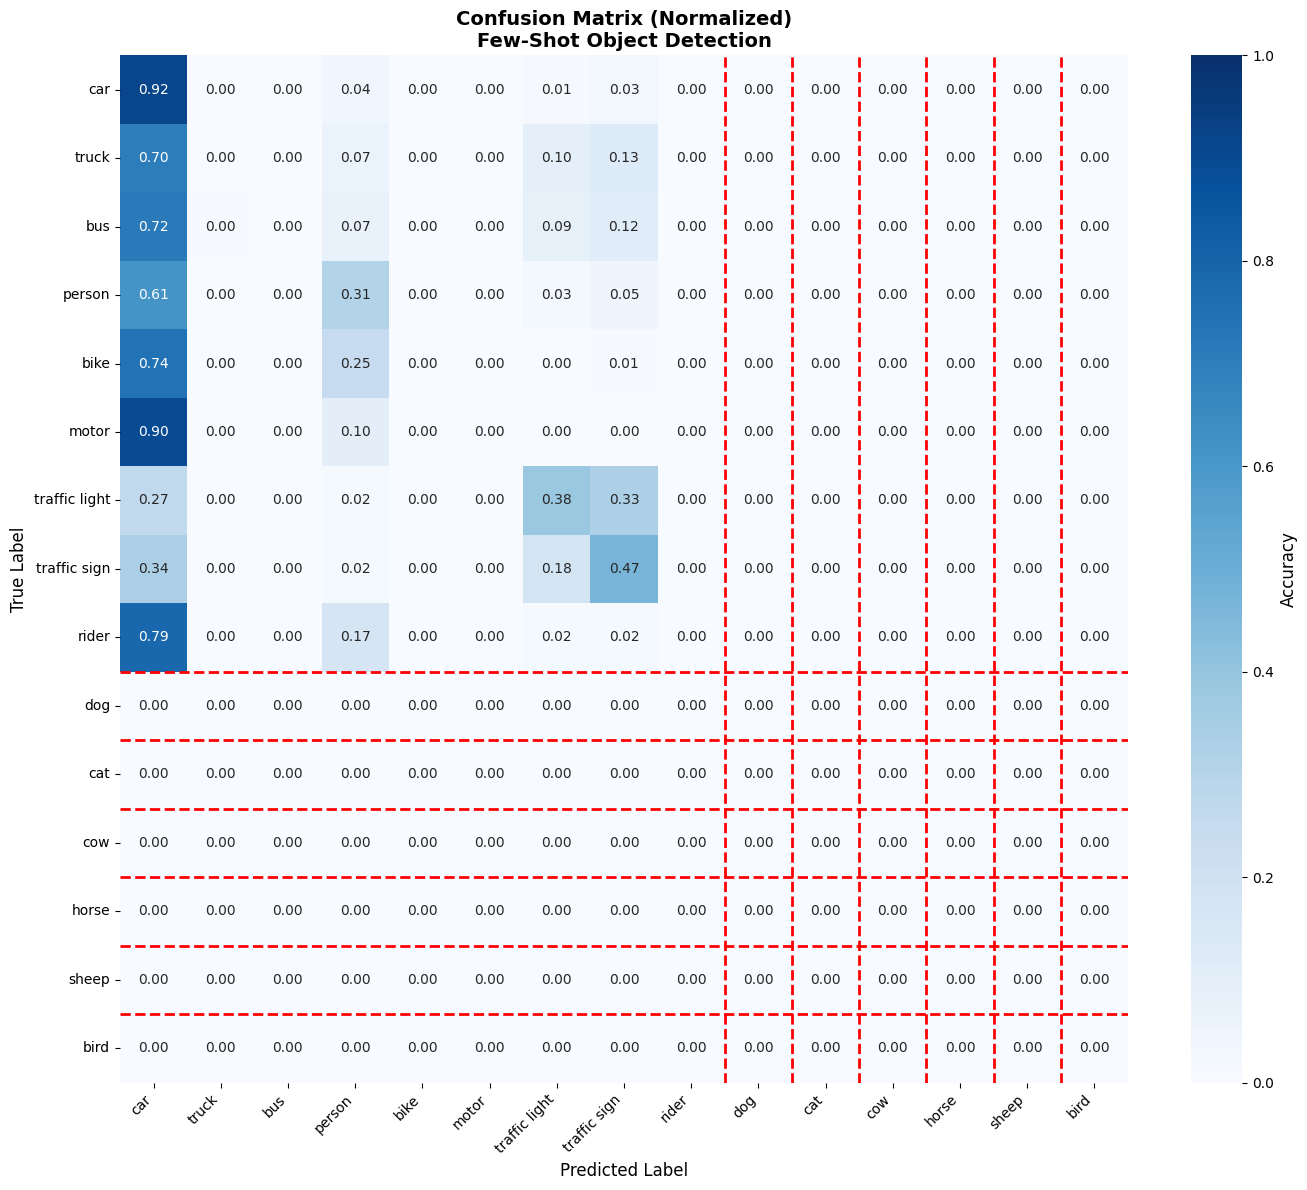

✓ Saved to /kaggle/working/outputs/confusion_matrix.png

📊 Raw Confusion Matrix:
------------------------------------------------------------
                    car   truck     bus  person    bike   motor  traffi  traffi   rider     dog     cat     cow   horse   sheep    bird
------------------------------------------------------------
            car   17455       1       1     732       3       5     277     521       0       0       0       0       0       0       0
          truck     468       0       0      46       0       0      64      86       0       0       0       0       0       0       0
            bus     178       1       0      18       0       0      22      29       0       0       0       0       0       0       0
         person    1431       1       0     723       3       0      63     106       0       0       0       0       0       0       0
           bike     139       0       0      47       0       0       0       1       0       0       0       0      

In [6]:
"""
=======================================================================
CONFUSION MATRIX
=======================================================================
"""

def create_confusion_matrix(model, loader, num_classes=15, conf_threshold=0.3):
    """Create confusion matrix from predictions"""
    model.eval()
    
    # Initialize confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # For each ground truth, find best matching prediction
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Building confusion matrix"):
            images = images.to(device)
            cls_out, _, obj_out = model(images)
            
            obj_conf = torch.sigmoid(obj_out)
            cls_prob = torch.sigmoid(cls_out)
            
            for i in range(images.size(0)):
                gt_labels = targets[i]['labels'].numpy()
                gt_boxes = targets[i]['boxes'].numpy()
                
                if len(gt_labels) == 0:
                    continue
                
                obj_i = obj_conf[i].max(dim=0)[0]
                cls_i = cls_prob[i]
                H, W = obj_i.shape
                
                for gt_lbl, gt_box in zip(gt_labels, gt_boxes):
                    if gt_lbl >= num_classes:
                        continue
                    
                    # Find prediction at GT location
                    cx = (gt_box[0] + gt_box[2]) / 2 / cfg.IMAGE_SIZE[1]
                    cy = (gt_box[1] + gt_box[3]) / 2 / cfg.IMAGE_SIZE[0]
                    gx = int(cx * W)
                    gy = int(cy * H)
                    gx = max(0, min(gx, W-1))
                    gy = max(0, min(gy, H-1))
                    
                    conf = obj_i[gy, gx].item()
                    if conf > conf_threshold:
                        pred_cls = cls_i[:, gy, gx].argmax().item()
                        cm[gt_lbl, pred_cls] += 1
                    else:
                        # No prediction - count as background/missed
                        pass
    
    return cm

print("\n📊 Generating Confusion Matrix...")
confusion_mat = create_confusion_matrix(model, val_loader, cfg.NUM_CLASSES)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))

# Normalize confusion matrix
cm_normalized = confusion_mat.astype('float') / (confusion_mat.sum(axis=1, keepdims=True) + 1e-10)

# Create heatmap
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=cfg.ALL_NAMES, yticklabels=cfg.ALL_NAMES,
            ax=ax, vmin=0, vmax=1)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix (Normalized)\nFew-Shot Object Detection', fontsize=14, fontweight='bold')

# Add color bar label
cbar = ax.collections[0].colorbar
cbar.set_label('Accuracy', fontsize=12)

# Rotate labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Highlight base vs novel
for i in range(cfg.NUM_BASE_CLASSES, cfg.NUM_CLASSES):
    ax.axhline(y=i, color='red', linewidth=2, linestyle='--')
    ax.axvline(x=i, color='red', linewidth=2, linestyle='--')

plt.tight_layout()
plt.savefig(f'{cfg.OUTPUT_DIR}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {cfg.OUTPUT_DIR}/confusion_matrix.png")

# Print raw confusion matrix
print("\n📊 Raw Confusion Matrix:")
print("-"*60)
print(f"{'':>15}", end='')
for name in cfg.ALL_NAMES:
    print(f"{name[:6]:>8}", end='')
print()
print("-"*60)
for i, name in enumerate(cfg.ALL_NAMES):
    print(f"{name:>15}", end='')
    for j in range(cfg.NUM_CLASSES):
        print(f"{confusion_mat[i,j]:>8}", end='')
    print()

In [7]:
"""
=======================================================================
FINAL METRICS CALCULATION
=======================================================================
"""

print("\n" + "="*70)
print("📊 FINAL EVALUATION METRICS")
print("="*70)

# Calculate metrics from confusion matrix
def calculate_metrics(cm):
    """Calculate precision, recall, F1 from confusion matrix"""
    metrics = {}
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[i] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': cm[i, :].sum()
        }
    
    return metrics

metrics = calculate_metrics(confusion_mat)

# Print metrics table
print(f"\n{'Class':<18} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10} {'Type':>10}")
print("="*70)

base_metrics = []
novel_metrics = []

for i in range(cfg.NUM_CLASSES):
    name = cfg.ALL_NAMES[i]
    m = metrics[i]
    cat_type = "Novel ★" if i >= cfg.NUM_BASE_CLASSES else "Base"
    
    print(f"{name:<18} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f} {m['support']:>10.0f} {cat_type:>10}")
    
    if i < cfg.NUM_BASE_CLASSES:
        base_metrics.append(m)
    else:
        novel_metrics.append(m)

print("="*70)

# Calculate averages
def avg_metrics(metrics_list):
    if not metrics_list:
        return {'precision': 0, 'recall': 0, 'f1': 0}
    return {
        'precision': np.mean([m['precision'] for m in metrics_list]),
        'recall': np.mean([m['recall'] for m in metrics_list]),
        'f1': np.mean([m['f1'] for m in metrics_list])
    }

base_avg = avg_metrics(base_metrics)
novel_avg = avg_metrics(novel_metrics)
overall_avg = avg_metrics(list(metrics.values()))

print(f"\n{'Base Classes Avg':<18} {base_avg['precision']:>10.4f} {base_avg['recall']:>10.4f} {base_avg['f1']:>10.4f}")
print(f"{'Novel Classes Avg':<18} {novel_avg['precision']:>10.4f} {novel_avg['recall']:>10.4f} {novel_avg['f1']:>10.4f}")
print(f"{'Overall Average':<18} {overall_avg['precision']:>10.4f} {overall_avg['recall']:>10.4f} {overall_avg['f1']:>10.4f}")


📊 FINAL EVALUATION METRICS

Class               Precision     Recall   F1-Score    Support       Type
car                    0.7880     0.9189     0.8484      18995       Base
truck                  0.0000     0.0000     0.0000        664       Base
bus                    0.0000     0.0000     0.0000        248       Base
person                 0.4184     0.3107     0.3566       2327       Base
bike                   0.0000     0.0000     0.0000        187       Base
motor                  0.0000     0.0000     0.0000         97       Base
traffic light          0.5138     0.3832     0.4390       3304       Base
traffic sign           0.5192     0.4668     0.4916       4257       Base
rider                  0.0000     0.0000     0.0000        109       Base
dog                    0.0000     0.0000     0.0000          0    Novel ★
cat                    0.0000     0.0000     0.0000          0    Novel ★
cow                    0.0000     0.0000     0.0000          0    Novel ★
horse    

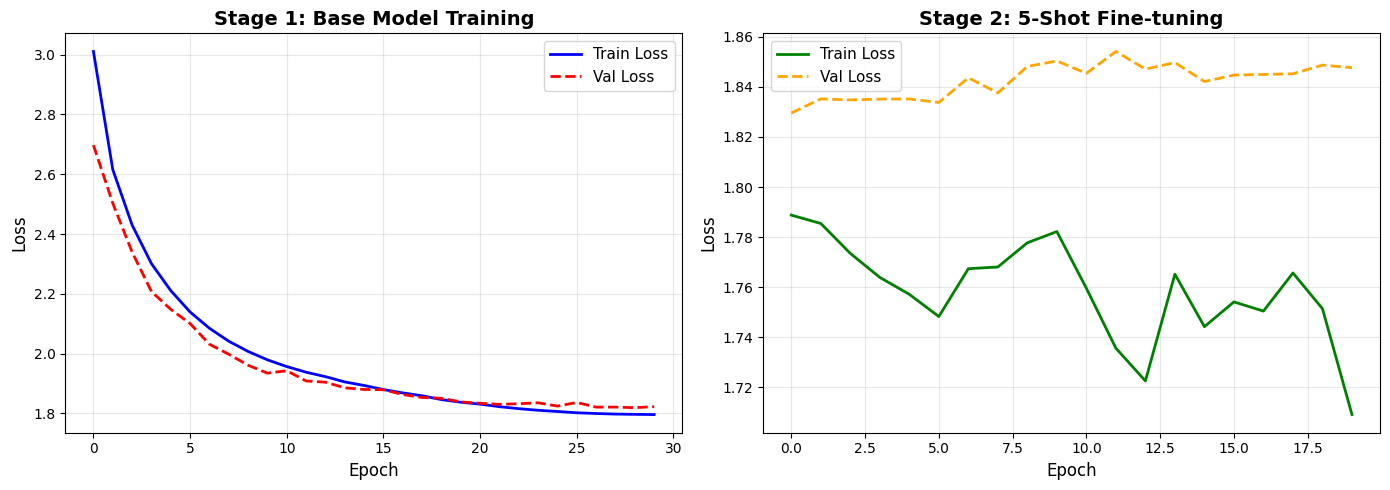

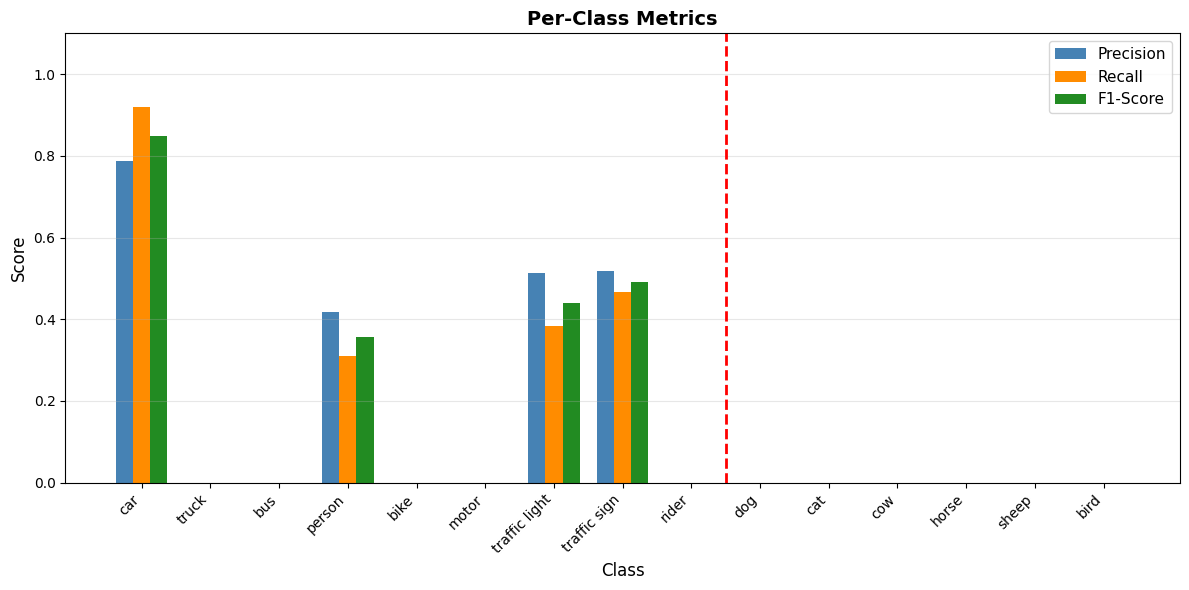

✓ Saved training curves and metrics chart


In [8]:
"""
=======================================================================
TRAINING CURVES AND FINAL SUMMARY
=======================================================================
"""

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stage 1
axes[0].plot(history['s1_train'], 'b-', linewidth=2, label='Train Loss')
axes[0].plot(history['s1_val'], 'r--', linewidth=2, label='Val Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Stage 1: Base Model Training', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Stage 2
axes[1].plot(history['s2_train'], 'g-', linewidth=2, label='Train Loss')
axes[1].plot(history['s2_val'], 'orange', linestyle='--', linewidth=2, label='Val Loss')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title(f'Stage 2: {cfg.K_SHOT}-Shot Fine-tuning', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{cfg.OUTPUT_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Metrics bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(cfg.NUM_CLASSES)
width = 0.25

precision_vals = [metrics[i]['precision'] for i in range(cfg.NUM_CLASSES)]
recall_vals = [metrics[i]['recall'] for i in range(cfg.NUM_CLASSES)]
f1_vals = [metrics[i]['f1'] for i in range(cfg.NUM_CLASSES)]

bars1 = ax.bar(x - width, precision_vals, width, label='Precision', color='steelblue')
bars2 = ax.bar(x, recall_vals, width, label='Recall', color='darkorange')
bars3 = ax.bar(x + width, f1_vals, width, label='F1-Score', color='forestgreen')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cfg.ALL_NAMES, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

# Add line to separate base and novel
ax.axvline(x=cfg.NUM_BASE_CLASSES - 0.5, color='red', linestyle='--', linewidth=2, label='Base | Novel')

plt.tight_layout()
plt.savefig(f'{cfg.OUTPUT_DIR}/metrics_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved training curves and metrics chart")

In [9]:
"""
=======================================================================
FINAL SUMMARY REPORT
=======================================================================
"""

print("\n")
print("╔" + "═"*70 + "╗")
print("║" + " "*20 + "FINAL RESULTS SUMMARY" + " "*29 + "║")
print("╠" + "═"*70 + "╣")
print("║" + " "*70 + "║")
print("║  📋 PROJECT: Few-Shot Learning for Novel Object Detection" + " "*11 + "║")
print("║  📅 Date: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " "*38 + "║")
print("║" + " "*70 + "║")
print("╠" + "═"*70 + "╣")
print("║  🏗️ MODEL ARCHITECTURE" + " "*47 + "║")
print("╠" + "═"*70 + "╣")
print(f"║  Backbone: {cfg.BACKBONE:<58}║")
print(f"║  Encoder: {cfg.ENCODER} (rates: {cfg.DILATION_RATES})" + " "*24 + "║")
print(f"║  Detection Head: {cfg.CLS_CONV_LAYERS} cls conv + {cfg.REG_CONV_LAYERS} reg conv layers" + " "*22 + "║")
print(f"║  Total Parameters: {total_params:,}" + " "*37 + "║")
print("║" + " "*70 + "║")
print("╠" + "═"*70 + "╣")
print("║  📊 TRAINING CONFIGURATION" + " "*43 + "║")
print("╠" + "═"*70 + "╣")
print(f"║  Stage 1: {cfg.STAGE1_EPOCHS} epochs, LR={cfg.STAGE1_LR}, Batch={cfg.STAGE1_BATCH_SIZE}" + " "*26 + "║")
print(f"║  Stage 2: {cfg.STAGE2_EPOCHS} epochs, LR={cfg.STAGE2_LR}, K-shot={cfg.K_SHOT}" + " "*26 + "║")
print(f"║  Loss: {cfg.LOSS_CLASSIFICATION} + {cfg.LOSS_REGRESSION}" + " "*32 + "║")
print("║" + " "*70 + "║")
print("╠" + "═"*70 + "╣")
print("║  📈 FINAL METRICS" + " "*52 + "║")
print("╠" + "═"*70 + "╣")
print(f"║  {'Category':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}    ║")
print("║  " + "-"*56 + "            ║")
print(f"║  {'Base Classes':<20} {base_avg['precision']:<12.4f} {base_avg['recall']:<12.4f} {base_avg['f1']:<12.4f}    ║")
print(f"║  {'Novel Classes ★':<20} {novel_avg['precision']:<12.4f} {novel_avg['recall']:<12.4f} {novel_avg['f1']:<12.4f}    ║")
print(f"║  {'Overall':<20} {overall_avg['precision']:<12.4f} {overall_avg['recall']:<12.4f} {overall_avg['f1']:<12.4f}    ║")
print("║" + " "*70 + "║")
print("╠" + "═"*70 + "╣")
print("║  📁 SAVED FILES" + " "*54 + "║")
print("╠" + "═"*70 + "╣")
print(f"║  • {cfg.OUTPUT_DIR}/base_model.pth" + " "*32 + "║")
print(f"║  • {cfg.OUTPUT_DIR}/fewshot_model.pth" + " "*29 + "║")
print(f"║  • {cfg.OUTPUT_DIR}/confusion_matrix.png" + " "*26 + "║")
print(f"║  • {cfg.OUTPUT_DIR}/training_curves.png" + " "*27 + "║")
print(f"║  • {cfg.OUTPUT_DIR}/metrics_chart.png" + " "*29 + "║")
print("║" + " "*70 + "║")
print("╚" + "═"*70 + "╝")

# Save summary to file
with open(f'{cfg.OUTPUT_DIR}/summary_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("FEW-SHOT LEARNING FOR NOVEL OBJECT DETECTION - RESULTS\n")
    f.write("="*70 + "\n\n")
    
    f.write("MODEL ARCHITECTURE\n")
    f.write("-"*40 + "\n")
    f.write(f"Backbone: {cfg.BACKBONE}\n")
    f.write(f"Encoder: {cfg.ENCODER}\n")
    f.write(f"Dilation Rates: {cfg.DILATION_RATES}\n")
    f.write(f"Parameters: {total_params:,}\n\n")
    
    f.write("TRAINING CONFIGURATION\n")
    f.write("-"*40 + "\n")
    f.write(f"Stage 1: {cfg.STAGE1_EPOCHS} epochs, LR={cfg.STAGE1_LR}\n")
    f.write(f"Stage 2: {cfg.STAGE2_EPOCHS} epochs, LR={cfg.STAGE2_LR}, K={cfg.K_SHOT}\n\n")
    
    f.write("FINAL METRICS\n")
    f.write("-"*40 + "\n")
    f.write(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}\n")
    for i in range(cfg.NUM_CLASSES):
        m = metrics[i]
        f.write(f"{cfg.ALL_NAMES[i]:<20} {m['precision']:<12.4f} {m['recall']:<12.4f} {m['f1']:<12.4f}\n")
    f.write("\n")
    f.write(f"Base Avg:   P={base_avg['precision']:.4f}, R={base_avg['recall']:.4f}, F1={base_avg['f1']:.4f}\n")
    f.write(f"Novel Avg:  P={novel_avg['precision']:.4f}, R={novel_avg['recall']:.4f}, F1={novel_avg['f1']:.4f}\n")
    f.write(f"Overall:    P={overall_avg['precision']:.4f}, R={overall_avg['recall']:.4f}, F1={overall_avg['f1']:.4f}\n")

print(f"\n✓ Summary saved to {cfg.OUTPUT_DIR}/summary_report.txt")
print("\n🎉 ALL EVALUATIONS COMPLETE!")



╔══════════════════════════════════════════════════════════════════════╗
║                    FINAL RESULTS SUMMARY                             ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📋 PROJECT: Few-Shot Learning for Novel Object Detection           ║
║  📅 Date: 2026-01-22 17:15:18                                      ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  🏗️ MODEL ARCHITECTURE                                               ║
╠══════════════════════════════════════════════════════════════════════╣
║  Backbone: CSPNet                                                    ║
║  Encoder: Dilated Convolution (rates: [2, 4, 6, 8])                        ║
║  Detection Head: 2 cls conv + 4 reg conv layers                      ║
║  Total Parameters: 21,360,988                 

In [10]:
import os
import shutil

# Path to kaggle working directory
source_dir = "/kaggle/working"
zip_path = "/kaggle/working/working_files"

# Create zip file
shutil.make_archive(zip_path, 'zip', source_dir)

print("Zipping completed:", zip_path + ".zip")


Zipping completed: /kaggle/working/working_files.zip


In [11]:
import shutil
from IPython.display import FileLink, display

# Zip the working directory
zip_path = "/kaggle/working/working_files"
shutil.make_archive(zip_path, 'zip', "/kaggle/working")

# Display download link in output box
display(FileLink(zip_path + ".zip"))


/kaggle/working/working_files.zip

In [12]:
from IPython.display import Image, display

image_path = "/kaggle/working/sample.png"  # change file name

display(Image(filename=image_path))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/sample.png'